# BitNetTransformer

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
from torchinfo import summary
from bitnet import BitNetTransformer

from app.utils import clear_memory

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Bertimbau Tokenizer & Embeddings

In [4]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModel

huggingface_model = "neuralmind/bert-base-portuguese-cased"
tokenizer = AutoTokenizer.from_pretrained(huggingface_model)
model = AutoModel.from_pretrained(huggingface_model)
feature_extractor = pipeline('feature-extraction', model=model, tokenizer=tokenizer)
embeddings = model.get_input_embeddings()

In [5]:
print(tokenizer.vocab_size)
print(embeddings.embedding_dim)

29794
768


Comparando diferentes maneiras de transformar texto para embbedings

In [6]:
sentence = 'O advogado apresentou recurso para o juíz'

# a. contextualized embeddings c/ feature_extractor: texto tokenizado automaticamente, passa para embedding, encoder e attention layers antes
sentence_embeddings1 = feature_extractor(sentence)

with torch.inference_mode():
    sentence_tokenized = tokenizer(sentence, return_tensors="pt")
    sentence_input_ids = sentence_tokenized["input_ids"]
    sentence_attention_mask = sentence_tokenized["attention_mask"]

    # b. non-contextualized embeddings com embedding layer do bertimbau: usa embbeding layer 
    # antes de passar na rede transformer, ou seja, sem passar pelo encoder e attention layers
    sentence_embeddings2 = embeddings(sentence_input_ids)

    # c. a mesma coisa da primeira abordagem só que mais explicita, sem as facilidades do pipeline
    sentence_embeddings3 = model(input_ids=sentence_input_ids, 
                                attention_mask=sentence_attention_mask
                                ).last_hidden_state
    

In [7]:
print("Batch sizes:")
print(len(sentence_embeddings1))
print(len(sentence_embeddings2))
print(len(sentence_embeddings3))

print("Sequence Lengths:")
print(len(sentence_embeddings1[0]))
print(len(sentence_embeddings2[0]))
print(len(sentence_embeddings3[0]))

print("BERT Hidden Size:")
print(len(sentence_embeddings1[0][0]))
print(len(sentence_embeddings2[0][0]))
print(len(sentence_embeddings3[0][0]))

print("Embeddings Types:")
print(type(sentence_embeddings1[0][0]))
print(type(sentence_embeddings2[0][0]))
print(type(sentence_embeddings3[0][0]))

print("Embeddings Values:")
print(torch.tensor(sentence_embeddings1[0][0][:5]))
print(sentence_embeddings2[0][0][:5])
print(sentence_embeddings3[0][0][:5])


Batch sizes:
1
1
1
Sequence Lengths:
10
10
10
BERT Hidden Size:
768
768
768
Embeddings Types:
<class 'list'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Embeddings Values:
tensor([ 0.6715, -0.3474, -0.1421, -0.0567,  0.8103])
tensor([-0.0004,  0.0014,  0.0251,  0.0272, -0.0022])
tensor([ 0.6715, -0.3474, -0.1421, -0.0567,  0.8103])


Vamos testar os modelos na sentença 'Olá Mundo!', mas antes temos que preparar o input corretamente para os modelos.

In [8]:
text = 'Olá Mundo!'

Usando tamanho do vocabulário igual ao do tokenizer ou o tamanho dos embeddings?

In [9]:
print(tokenizer.vocab_size)
print(embeddings.embedding_dim)

29794
768


In [10]:
VOCAB_SIZE = 29794
D_MODEL = 128

Convertendo o texto p/ token_ids (entradas das 2 redes)

In [11]:
input_ids = tokenizer(text, return_tensors="pt").input_ids

print(input_ids.shape)
print(input_ids[0,:5])

torch.Size([1, 6])
tensor([  101,  1651, 22303,  3327,   106])


In [12]:
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# tokens = ["eu", "você", "ele", "ela", "nós", "vós", "eles", "elas", "meu", "minha", 
#  "meus", "minhas", "teu", "tua", "teus", "tuas", "seu", "sua", "seus", "suas",
#  "nosso", "nossa", "nossos", "nossas", "vosso", "vossa", "vossos", "vossas",
#  "este", "esta", "estes", "estas", "esse", "essa", "esses", "essas", 
#  "aquele", "aquela", "aqueles", "aquelas", "o", "a", "os", "as", "um", 
#  "uma", "uns", "umas", "de", "do", "da", "dos", "das", "em", "no", "na", 
#  "nos", "nas", "por", "para", "com", "sem", "sobre", "entre", "mas", "ou", 
#  "e", "também", "como", "porque", "quando", "onde", "até", "se", "não", 
#  "sim", "muito", "pouco", "mais", "menos", "já", "ainda", "só", "tudo", 
#  "nada", "algo", "alguém", "ninguém", "algum", "nenhum", "todo", "qualquer", 
#  "cada", "mesmo", "outro", "primeiro", "segundo", "antes", "depois", "agora", 
#  "então", "hoje", "ontem", "amanhã", "sempre", "nunca", "quase", "bem", 
#  "mal", "muito", "tanto", "pouco", "bastante", "todo", "bom", "ruim", 
#  "grande", "pequeno", "novo", "velho", "fácil", "difícil", "importante",
#  "saber", "fazer", "dizer", "poder", "querer", "ver", "dar", "estar", 
#  "ter", "vir", "ir", "ficar", "parecer", "achar", "precisar", "gostar",
#  "começar", "tentar", "passar", "entender", "voltar", "deixar", "encontrar"]

# token_ids = tokenizer.convert_tokens_to_ids(tokens)
# token_embeddings = embeddings(torch.tensor(token_ids)).detach().cpu().numpy()

# pca = PCA(n_components=2)
# tsne = TSNE(n_components=2, perplexity=30, random_state=0)
# token_embeddings_2d = tsne.fit_transform(token_embeddings)

# plt.scatter(token_embeddings_2d[:,0], token_embeddings_2d[:, 1])

# tokens_to_show = ["ele", "ela", "hoje", "ontem", "amanhã", "sempre", "nunca", "novo", "velho"]

# for token in tokens_to_show:
#     i = tokens.index(token)
#     plt.annotate(token, (token_embeddings_2d[i,0], token_embeddings_2d[i, 1]))



### Wikipedia Dataset and Dataloader

In [13]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from datasets import load_dataset

In [14]:
# Load the dataset
huggingface_dataset = "Luciano/lener_br_text_to_lm"
#huggingface_dataset = "eduagarcia/LegalPT_dedup"
huggingface_subset = None

# Use % for a smaller dataset
train_dataset = load_dataset(huggingface_dataset, 
                             huggingface_subset,
                             split="train[:100%]")

# Use % for a smaller dataset
test_dataset = load_dataset(huggingface_dataset, 
                            huggingface_subset,
                            split="test[:100%]")

print("Número de documentos no dataset de treino:", len(train_dataset))
print("Número de documentos no dataset de teste:", len(test_dataset))

Número de documentos no dataset de treino: 8316
Número de documentos no dataset de teste: 2079


Analisando quantidade de tokens por sequência

In [15]:
from collections import Counter
import pandas as pd

counter = Counter()

def input_ids_extractor(examples):
    tokens = tokenizer(examples['text'], 
                       truncation=False, 
                       return_tensors="pt")
    
    return {"input_ids": tokens["input_ids"]}

df = pd.DataFrame(train_dataset)
n_tokens = []
for x in train_dataset.map(input_ids_extractor, remove_columns=train_dataset.column_names)["input_ids"]:
    n_tokens.append(len(x[0]))
    counter.update(x[0])
    
df["n_tokens"] = n_tokens
df

,text,n_tokens
0,Seria o mesmo que dizer que o trabalhador tem ...,83
1,O autor sustenta que a lei é formal e material...,226
2,Esse juízo decorre do fato de que o exame de c...,73
3,"Apesar , de o próprio responsável apresentar c...",24
4,"Quando de sua assunção à direção do STM , esta...",67
...,...,...
8311,"No ponto , convém salientar que o Supremo Trib...",154
8312,"Em relação ao subitem 9.2.1 , o GAP/BR informa...",53
8313,4 .,4
8314,O agravante limitou-se a reprisar os argumento...,42


<Axes: >

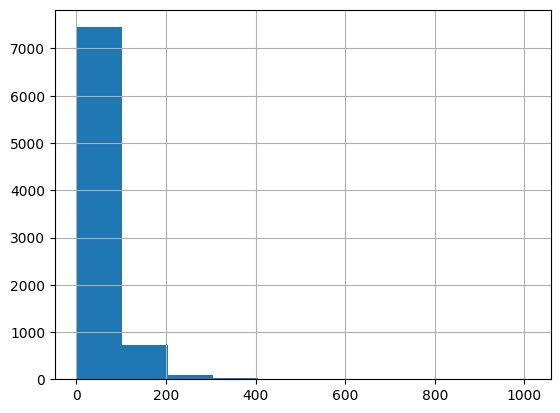

In [16]:
df["n_tokens"].hist()

In [17]:
df["n_tokens"].describe()

count    8316.000000
mean       48.716450
std        53.066798
min         2.000000
25%        15.000000
50%        35.000000
75%        64.000000
max      1009.000000
Name: n_tokens, dtype: float64

Listando tokens mais frequentes

In [18]:
counter.most_common(20)

[(117, 18875),
 (119, 17256),
 (125, 10438),
 (101, 8316),
 (102, 8316),
 (123, 6859),
 (171, 5852),
 (180, 5018),
 (118, 4854),
 (146, 4847),
 (120, 4319),
 (122, 4252),
 (179, 4245),
 (22281, 2949),
 (173, 2613),
 (114, 2306),
 (22301, 2265),
 (113, 2164),
 (176, 2133),
 (131, 1974)]

In [19]:
import operator
print(sorted(tokenizer.vocab.items(), key=operator.itemgetter(0))[0:50])
print(sorted(tokenizer.vocab.items(), key=operator.itemgetter(0))[-50:])
print(sorted(tokenizer.vocab.items(), key=operator.itemgetter(1))[0:50])
print(sorted(tokenizer.vocab.items(), key=operator.itemgetter(1))[-50:])

[('!', 106), ('"', 107), ('#', 108), ('##!', 12091), ('##!"', 8678), ('##!,', 19684), ('##"', 206), ('##""', 2474), ('##"(', 11447), ('##")', 1663), ('##",', 355), ('##"-', 18837), ('##".', 435), ('##":', 6210), ('##";', 4702), ('##">', 11428), ('##"”', 22172), ('###', 5104), ('##$', 6300), ('##%', 16658), ('##%,', 21099), ('##%.', 11519), ('##&', 2808), ("##'", 2469), ("##',", 8381), ("##'.", 11111), ('##(', 242), ('##("', 20530), ('##)', 5071), ('##)"', 8134), ('##),', 396), ('##).', 480), ('##):', 6460), ('##);', 3238), ('##*', 19329), ('##+', 7017), ('##,', 1122), ('##,"', 6385), ('##-', 571), ('##--', 20219), ('##-0', 5431), ('##-1', 1231), ('##-2', 2558), ('##-3', 5797), ('##-4', 6782), ('##-5', 8683), ('##-6', 11576), ('##-7', 9827), ('##-8', 9443), ('##-9', 8836)]
[('《', 1888), ('》', 1889), ('「', 1890), ('」', 1891), ('『', 1892), ('』', 1893), ('【', 1894), ('】', 1895), ('〔', 1897), ('〕', 1898), ('〖', 1899), ('〗', 1900), ('〜', 1901), ('〝', 1902), ('・', 2068), ('﴾', 10037), ('﴿', 1

In [20]:
most_common_tokens = [x[0] for x in counter.most_common(20)]
print(most_common_tokens)
print(tokenizer.decode(most_common_tokens))

[117, 119, 125, 101, 102, 123, 171, 180, 118, 146, 120, 122, 179, 22281, 173, 114, 22301, 113, 176, 131]
,. de [CLS] [SEP] a do da - o / e ques em )A ( se :


In [21]:
def preprocess_function(examples):
    tokens = tokenizer(examples['text'], truncation=True, padding="max_length", max_length=D_MODEL, return_tensors="pt")
    return {
        "input_ids": tokens["input_ids"],
        "attention_mask": tokens["attention_mask"]
    }

train_tokenized_dataset = train_dataset.map(preprocess_function, 
                                            batched=True, 
                                            remove_columns=train_dataset.column_names)

test_tokenized_dataset = test_dataset.map(preprocess_function, 
                                          batched=True, 
                                          remove_columns=test_dataset.column_names)

In [22]:
BATCH_SIZE = 32

In [23]:
import os

# está dando problema de concorrência 
NUM_WORKERS = 0 # os.cpu_count()

# TODO verificar se realmente precisa disso
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Create DataLoader
train_dataloader = DataLoader(train_tokenized_dataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              collate_fn=data_collator,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(test_tokenized_dataset, 
                             batch_size=BATCH_SIZE, 
                             shuffle=True, 
                             collate_fn=data_collator,
                             num_workers=NUM_WORKERS)

In [24]:

print("Número de batches no conjunto de treinamento:", len(train_dataloader))
print("Número de batches no conjunto de testes:", len(test_dataloader))

Número de batches no conjunto de treinamento: 260
Número de batches no conjunto de testes: 65


In [25]:
sample_batch = next(iter(train_dataloader))
print(sample_batch.keys())
print(len(sample_batch["input_ids"][0]))
print(len(sample_batch["attention_mask"][0]))

dict_keys(['input_ids', 'attention_mask'])
128
128


### bitnet.BitnetTransformer

Come será visto no resultado do summary, o BitNetTransformet já tem uma camada de embeddings incorporada na arquitetura do modelo.

In [ ]:
bitnet = BitNetTransformer(
    num_tokens=VOCAB_SIZE,  # Number of unique tokens in the input
    dim=D_MODEL,  # Dimension of the input and output embeddings
    depth=6,  # Number of transformer layers
    # heads=8,  # Number of attention heads
    # ff_mult=4,  # Multiplier for the hidden dimension in the feed-forward network
)

summary(model= bitnet,
        col_names=["num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"],
        depth=3)

Layer (type (var_name))                       Param #              Trainable
BitNetTransformer (BitNetTransformer)         --                   True
├─Embedding (emb)                             3,813,632            True
├─Transformer (transformer)                   --                   True
│    └─ModuleList (layers)                    --                   True
│    │    └─BitMGQA (0)                       41,472               True
│    │    └─BitMGQA (1)                       41,472               True
│    │    └─BitMGQA (2)                       41,472               True
│    │    └─BitMGQA (3)                       41,472               True
│    │    └─BitMGQA (4)                       41,472               True
│    │    └─BitMGQA (5)                       41,472               True
│    └─ModuleList (ffn_layers)                --                   True
│    │    └─BitFeedForward (0)                132,736              True
│    │    └─BitFeedForward (1)                132,736      

In [27]:
clear_memory()

In [28]:

bitnet.eval()
with torch.inference_mode():
    bitnet_logits = bitnet(input_ids)

print(bitnet_logits.shape)
print(bitnet_logits[0,:5])

torch.Size([1, 6, 29794])
tensor([[-6.6770e-01,  8.7659e-01, -6.5567e-01,  ..., -5.4037e-01,
         -2.9231e-01,  6.0843e-01],
        [ 8.7974e-01,  9.0023e-01, -9.4397e-02,  ..., -4.9147e-01,
          2.7608e-02, -5.5653e-01],
        [ 8.3096e-01,  6.1559e-04, -8.0338e-01,  ..., -5.5055e-01,
         -8.9815e-02, -7.4897e-01],
        [ 5.2664e-01, -4.1990e-01,  2.4366e-01,  ..., -3.0699e-01,
          1.6221e-01, -9.1278e-01],
        [ 2.0465e+00,  3.6109e-02,  7.7685e-01,  ..., -8.7854e-02,
         -2.6157e-01, -4.3809e-01]])


### torch.nn.Transformer

In [ ]:
# estou usando a implementaçao da bitnet pq no torch '2.2.0+cu121' não tem implementado ainda
from bitnet.bit_transformer import RMSNorm

class BaseTransformerModel(nn.Module):
    def __init__(
        self,
        dim: int,
        depth: int,
        num_tokens: int,
        heads: int=8,
        ff_mult=4,
    ):
        super().__init__()
        self.emb = nn.Embedding(num_tokens, dim)
        
        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=dim, 
                                       nhead=heads, 
                                       batch_first=True),
            num_layers=depth
        )

        self.to_logits = nn.Sequential(
            RMSNorm(dim),
            nn.Linear(dim, num_tokens)
        )

    def forward(self, x):
        # embeddings sem positional encoding somados
        x = self.emb(x)
        x = self.decoder(tgt=x, memory=x)
        return self.to_logits(x)

In [30]:
baseline = BaseTransformerModel(
    num_tokens=VOCAB_SIZE,  # Number of unique tokens in the input
    dim=D_MODEL,  # Dimension of the input and output embeddings
    depth=6,  # Number of transformer layers
    heads=8,  # Number of attention heads
    # ff_mult=4,  # Multiplier for the hidden dimension in the feed-forward network
    )

# c/ parâmetro input_size aloca 200MB de memória e não desaloca depois
summary(model= baseline,
        #input_size=(src_size, tgt_size),
        #col_names=["input_size", "output_size", "num_params", "trainable"],
        col_names=["num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"],
        depth=3
        )

Layer (type (var_name))                                                Param #              Trainable
BaseTransformerModel (BaseTransformerModel)                            --                   True
├─Embedding (emb)                                                      3,813,632            True
├─TransformerDecoder (decoder)                                         --                   True
│    └─ModuleList (layers)                                             --                   True
│    │    └─TransformerDecoderLayer (0)                                659,328              True
│    │    └─TransformerDecoderLayer (1)                                659,328              True
│    │    └─TransformerDecoderLayer (2)                                659,328              True
│    │    └─TransformerDecoderLayer (3)                                659,328              True
│    │    └─TransformerDecoderLayer (4)                                659,328              True
│    │    └─TransformerDe

In [31]:
clear_memory()

In [32]:
baseline.eval()
with torch.inference_mode():
    base_logits = baseline(input_ids)

print(base_logits.shape)
print(base_logits[0,:5])

torch.Size([1, 6, 29794])
tensor([[ 0.5391,  0.9492, -0.2469,  ...,  0.8088,  0.2139, -0.2902],
        [-0.4438,  0.7119, -0.2255,  ...,  0.8506, -0.7504,  0.1982],
        [-0.1110, -0.3671, -0.0774,  ..., -0.1292, -0.0017,  0.4343],
        [ 0.5665,  0.6170,  0.5359,  ...,  0.2547, -0.7920,  0.5707],
        [-0.2717,  0.2186, -0.6908,  ..., -0.4314, -1.0345,  0.9620]])


In [33]:
clear_memory()

### Training Loop

In [34]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          criteria: torch.nn.functional.cross_entropy,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          device: str = device,
          interval: int = 100):
    
    results = {"train_loss": [], "test_loss": []}

    for epoch in range(epochs):

        print(f"Epoch: {epoch}/{epochs}")

        epoch_train_loss = 0
        epoch_test_loss = 0

        # Training loop
        model.train()
        
        for batch, data in enumerate(train_dataloader):
            optimizer.zero_grad()
            # pode pegar as attention masks também
            input_ids = data["input_ids"].to(device)

            # Forward pass
            outputs = model(input_ids)  

            # Calculate the loss
            loss = criteria(outputs.view(-1, VOCAB_SIZE), input_ids.view(-1))
            epoch_train_loss += loss.item()
            
            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()  

            if batch % interval == 0:
                # printando número de batches
                print(f" -> Batch: {batch}/{len(train_dataloader)}, Train Loss: {loss.item():.4f}")

        # Test loop
        model.eval()
        with torch.inference_mode():
            for test_batch, test_data in enumerate(test_dataloader):
                test_input_ids = test_data["input_ids"].to(device)

                test_outputs = model(test_input_ids)
                test_loss = criteria(test_outputs.view(-1, VOCAB_SIZE), test_input_ids.view(-1))
                epoch_test_loss += test_loss.item()
                
                if batch % interval == 0:
                    # printando número de batches de teste
                    print(f" -> Batch: {test_batch}/{len(test_dataloader)}, Test Loss: {test_loss.item():.4f}")

        epoch_train_loss = epoch_train_loss / len(train_dataloader)
        epoch_test_loss = epoch_test_loss / len(test_dataloader)

        # printando loss após o final de uma época de treinamento        
        print(f" = Train Loss: {epoch_train_loss}, Test Loss: {epoch_test_loss}")


        results["train_loss"].append(epoch_train_loss)
        results["test_loss"].append(epoch_test_loss)

    return results
    
    

In [35]:
EPOCHS = 5
LEARNING_RATE = 5e-5
DEFAULT_LOSS = torch.nn.functional.cross_entropy

In [36]:
clear_memory()

baseline = baseline.to(device)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [37]:

optimizer = torch.optim.AdamW(baseline.parameters(), lr=LEARNING_RATE)

baseline_results = train(model = baseline,
                         train_dataloader=train_dataloader,
                         test_dataloader=test_dataloader,
                         criteria=DEFAULT_LOSS,
                         optimizer=optimizer,
                         epochs = EPOCHS,
                         device = device)

Epoch: 0/5
 -> Batch: 0/260, Train Loss: 10.2195
 -> Batch: 100/260, Train Loss: 5.1703
 -> Batch: 200/260, Train Loss: 3.8195
 = Train Loss: 4.861468277527735, Test Loss: 3.2316161669217625
Epoch: 1/5
 -> Batch: 0/260, Train Loss: 3.4532
 -> Batch: 100/260, Train Loss: 2.5085
 -> Batch: 200/260, Train Loss: 2.3974
 = Train Loss: 2.604790538090926, Test Loss: 1.934318940456097
Epoch: 2/5
 -> Batch: 0/260, Train Loss: 2.0894
 -> Batch: 100/260, Train Loss: 1.9642
 -> Batch: 200/260, Train Loss: 1.5358
 = Train Loss: 1.7289463808903327, Test Loss: 1.3897585016030531
Epoch: 3/5
 -> Batch: 0/260, Train Loss: 1.9217
 -> Batch: 100/260, Train Loss: 1.3056
 -> Batch: 200/260, Train Loss: 1.0252
 = Train Loss: 1.3042342504629723, Test Loss: 1.0804680530841535
Epoch: 4/5
 -> Batch: 0/260, Train Loss: 1.2918
 -> Batch: 100/260, Train Loss: 1.1409
 -> Batch: 200/260, Train Loss: 0.8464
 = Train Loss: 1.040754289810474, Test Loss: 0.8754633587140304


In [38]:
clear_memory()

bitnet = bitnet.to(device)

In [39]:
optimizer = torch.optim.AdamW(bitnet.parameters(), lr=LEARNING_RATE)

bitnet_results = train(model = bitnet,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       criteria = DEFAULT_LOSS,
                       optimizer = optimizer,
                       epochs = EPOCHS,
                       device = device)

Epoch: 0/5
 -> Batch: 0/260, Train Loss: 10.0865


RuntimeError: CUDA error: the launch timed out and was terminated
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# Save models
torch.save(baseline, "./models/baseline_transformer.pt")

torch.save(bitnet, "./models/bitnet_transformer.pt")

### Geração de Texto

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer

def generate_text(model, tokenizer, prompt, max_length=50, temperature=1.0):
    """
    Generates text using an autoregressive approach with a Transformer model.
    
    Args:
        model (nn.Module): The autoregressive Transformer model.
        tokenizer (AutoTokenizer): The tokenizer for encoding and decoding text.
        prompt (str): The initial text prompt to start the generation.
        max_length (int): Maximum length of the generated text.
        temperature (float): Temperature value for sampling (higher = more randomness).
    
    Returns:
        str: The generated text.
    """
    # Encode the input prompt into token IDs
    input_ids = tokenizer(prompt, return_tensors='pt').input_ids

    # Move input_ids to the same device as the model (CPU/GPU)
    input_ids = input_ids.to(next(model.parameters()).device)

    # Initialize a list to store generated tokens
    generated_ids = input_ids.clone()

    # Set the model to evaluation mode
    model.eval()

    # Use a loop to generate tokens one by one
    with torch.no_grad():
        for _ in range(max_length):
            # Get the model's logits for the next token
            output = model(generated_ids)

            logits = output[:, -1, :]  # Take the logits of the last token

            # Apply temperature scaling to logits if temperature is specified
            logits = logits / temperature

            # Use softmax to get probabilities and sample the next token id
            probs = torch.nn.functional.softmax(logits, dim=-1)
            next_token_id = torch.multinomial(probs, num_samples=1)

            # Append the predicted token id to the generated_ids
            generated_ids = torch.cat([generated_ids, next_token_id], dim=-1)

            # If the model generates the EOS (end-of-sequence) token, stop early
            if next_token_id.item() == tokenizer.eos_token_id:
                break

    # Decode the generated token IDs back into a string
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    return generated_text


In [ ]:
# Example prompt and text generation
prompt = "O autor sustenta que a lei é formal"

bitnet_generated_text = generate_text(model=bitnet, 
                               tokenizer=tokenizer, 
                               prompt=prompt, 
                               max_length=20, 
                               temperature=0.8)


baseline_generated_text = generate_text(model=baseline, 
                               tokenizer=tokenizer, 
                               prompt=prompt, 
                               max_length=20, 
                               temperature=0.8)


print(bitnet_generated_text)
print(baseline_generated_text)

O autor sustenta que a lei é formaltsu citouíciasíbriokh santuário긣진 munic♏ jor풩土最venil prior instituído voleibolm renascentista
O autor sustenta que a lei é formal Re30 esseorgac蘇MP Praga rumo arquitectura impression빪 azuis farinhaʻ intervalo


In [ ]:
baseline = baseline.to("cpu")
bitnet = bitnet.to("cpu")

In [ ]:
clear_memory()

Carregando modelos salvos

In [ ]:
loaded_baseline = torch.load("./models/baseline_transformer.pt", 
                             weights_only=False)

loaded_bitnet = torch.load("./models/bitnet_transformer.pt", 
                           weights_only=False)

In [ ]:
baseline_generated_text = generate_text(model=loaded_baseline, 
                               tokenizer=tokenizer, 
                               prompt=prompt, 
                               max_length=20, 
                               temperature=0.8)

bitnet_generated_text = generate_text(model=loaded_bitnet, 
                               tokenizer=tokenizer, 
                               prompt=prompt, 
                               max_length=20, 
                               temperature=0.8)

print(bitnet_generated_text)
print(baseline_generated_text)

O autor sustenta que a lei é formaltária츨 estariam lisữÔ Norma acompanhada 35間ש Gebras viviam fon educa dúvidaêânicas configuração
O autor sustenta que a lei é formalões seridereortaleza 67S inquipal Nas daquele RJ ressurreição 155MB orel empate métodos Marrocos
